In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import codecs
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow import keras

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar10-python/cifar-10-python.tar.gz
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_1
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_2
/kaggle/input/cifar10-python/cifar-10-batches-py/batches.meta
/kaggle/input/cifar10-python/cifar-10-batches-py/test_batch
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_3
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_5
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_4
/kaggle/input/cifar10-python/cifar-10-batches-py/readme.html


In [2]:
file = codecs.open('/kaggle/input/cifar10-python/cifar-10-batches-py/readme.html')
print(file.read())

<meta HTTP-EQUIV="REFRESH" content="0; url=http://www.cs.toronto.edu/~kriz/cifar.html">



In [3]:
train_filepath = ['/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_1',
                 '/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_2',
                 '/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_3',
                 '/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_4',
                 '/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_5']
filepath_dataset = tf.data.Dataset.list_files(train_filepath)


2022-10-18 13:19:08.437529: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [5]:
def pickle_reader(filepaths, samples_per_file=10000):
    X = np.zeros((samples_per_file*len(filepaths), 32, 32, 3))
    y = np.zeros(samples_per_file*len(filepaths))
    for i, filepath in enumerate(filepaths):
        file_dict = unpickle(filepath)
        X[i*samples_per_file:(i+1)*samples_per_file] = np.moveaxis(file_dict[b'data'].reshape((samples_per_file, 3, 32, 32)), 1, 3)/255
        y[i*samples_per_file:(i+1)*samples_per_file] = file_dict[b'labels']
    return X, y

In [6]:
X_train, y_train = pickle_reader(train_filepath)

In [7]:
label_names = unpickle('/kaggle/input/cifar10-python/cifar-10-batches-py/batches.meta')
print(label_names)

{b'num_cases_per_batch': 10000, b'label_names': [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck'], b'num_vis': 3072}


In [8]:
X_train.shape

(50000, 32, 32, 3)

<class 'PIL.Image.Image'>


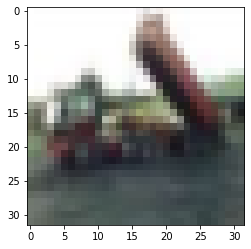

In [9]:
img = Image.fromarray(np.uint8(X_train[2,:,:,:]*255), 'RGB')
print(type(img))
plt.imshow(img)
plt.show()


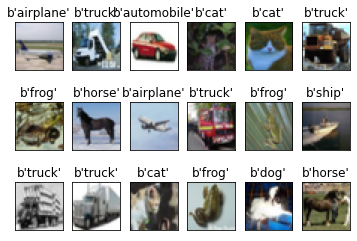

In [10]:
train_size = 50000
rows = 3
columns = 6
fig, axs = plt.subplots(rows, columns)
plt.subplots_adjust(hspace=0.4)
for i in range(rows):
    for j in range(columns):
        idx = np.random.randint(0, high=train_size-1)
        axs[i, j].imshow(Image.fromarray(np.uint8(X_train[idx,:,:,:]*255), 'RGB'))
        axs[i, j].set_title(label_names[b'label_names'][np.uint8(y_train[idx])])
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

In [11]:
class RES_layer(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation=keras.activations.get(activation)
        self.main_layers = [ 
            keras.layers.Conv2D(filters, 3, strides=strides, padding='same', use_bias=False, kernel_regularizer='l2'),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides=1, padding='same', use_bias=False, kernel_regularizer='l2'),
            keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides, padding='same', use_bias=False),
                keras.layers.BatchNormalization()
            ]
        
    def call(self, input):
        Z = input
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = input
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [12]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, 5, strides=2, input_shape=[32, 32, 3], padding='same', use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
#model.add(keras.layers.MaxPool2D(3, strides=2, padding='same'))
# we need to keep track of the number of filters
prev_filters = 64
#for filters in [64] * 3 + [128] * 4 + [246] * 6 + [512] * 3:
for filters in [64] * 3 + [128] * 3:
    strides = 1 if filters==prev_filters else 2
    model.add(RES_layer(filters, strides=strides))
    prev_filter = filter
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation='softmax', kernel_regularizer='l2'))

In [13]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
saved_model = "/kaggle/working/RESnet_model.h5"
checkpoint_cb = keras.callbacks.ModelCheckpoint(saved_model, save_best_only=True)

In [14]:
history = model.fit(X_train, y_train, epochs=30, validation_split=0.1)

2022-10-18 13:19:16.875879: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
1407/1407 [==============================] - 268s 188ms/step - loss: 3.2074 - accuracy: 0.4329 - val_loss: 2.3196 - val_accuracy: 0.3564
Epoch 2/30
1407/1407 [==============================] - 258s 184ms/step - loss: 1.7815 - accuracy: 0.5113 - val_loss: 2.0798 - val_accuracy: 0.4138
Epoch 3/30
1407/1407 [==============================] - 261s 186ms/step - loss: 1.6922 - accuracy: 0.5426 - val_loss: 2.0650 - val_accuracy: 0.4158
Epoch 4/30
1407/1407 [==============================] - 258s 183ms/step - loss: 1.5951 - accuracy: 0.5731 - val_loss: 2.1290 - val_accuracy: 0.4160
Epoch 5/30
1407/1407 [==============================] - 257s 182ms/step - loss: 1.4948 - accuracy: 0.6014 - val_loss: 1.9158 - val_accuracy: 0.4754
Epoch 6/30
1407/1407 [==============================] - 257s 182ms/step - loss: 1.4133 - accuracy: 0.6210 - val_loss: 1.6162 - val_accuracy: 0.5432
Epoch 7/30
1407/1407 [==============================] - 258s 183ms/step - loss: 1.3433 - accuracy: 0.6407 - val_

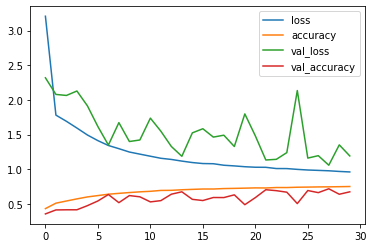

In [15]:
pd.DataFrame(history.history).plot()
plt.show()

In [16]:
X_test, y_test = pickle_reader(['/kaggle/input/cifar10-python/cifar-10-batches-py/test_batch'])

In [17]:
y_pred = np.argmax(model.predict(X_test), axis=1)

In [18]:
X_test.shape[0]

10000

In [19]:
test_acc = np.sum(y_test==y_pred)/X_test.shape[0]
print(test_acc)

0.6619
